## Creation of Superblocks... code will be put into class Block_Group

In [17]:
import geopandas as gpd
def find_adjacent_blocks(block, gdf):
    """
    Finds blocks adjacent to the given block.
    
    Parameters:
    - block: The GeoDataFrame row of the current block.
    - gdf: The entire GeoDataFrame of blocks.
    
    Returns:
    - A GeoDataFrame of adjacent blocks.
    """
    # Use the touches method to find blocks that share a boundary with the current block
    adjacent = gdf[gdf.geometry.touches(block.geometry)]
    return adjacent

def group_blocks(gdf, target_population, margin=1000):
    """
    
    Groups blocks into supergroups based on adjacency and population criteria.
    
    Parameters:
    - gdf: GeoDataFrame containing all blocks with their population.
    - target_population: The target population for each group.
    - margin: The margin of error for the target population.
    
    Returns:
    - A list of GeoDataFrames, each representing a grouped superblock.
    """
    grouped_blocks = []
    visited = set()
    
    for index, block in gdf.iterrows():
        if index in visited:
            continue
        
        current_group = [block]
        current_population = block['VALUE9']
        queue = [block]
        visited.add(index)
        
        while queue:
            current_block = queue.pop(0)
            if current_population >= target_population - margin and current_population <= target_population + margin:
                break
            
            adjacents = find_adjacent_blocks(current_block, gdf)
            
            for _, adj_block in adjacents.iterrows():
                adj_index = adj_block.name
                if adj_index not in visited and current_population + adj_block['VALUE9'] <= target_population + margin:
                    visited.add(adj_index)
                    current_group.append(adj_block)
                    current_population += adj_block['VALUE9']
                    queue.append(adj_block)
        
        if current_group:
            grouped_blocks.append(gpd.GeoDataFrame(current_group))
    
    return grouped_blocks

In [18]:
target_population = 19000
gdf = gpd.read_file("datasets")
margin = 2000
supergroups = group_blocks(gdf, target_population, margin)

/tmp/ipykernel_419271/426014191.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(supergroups))


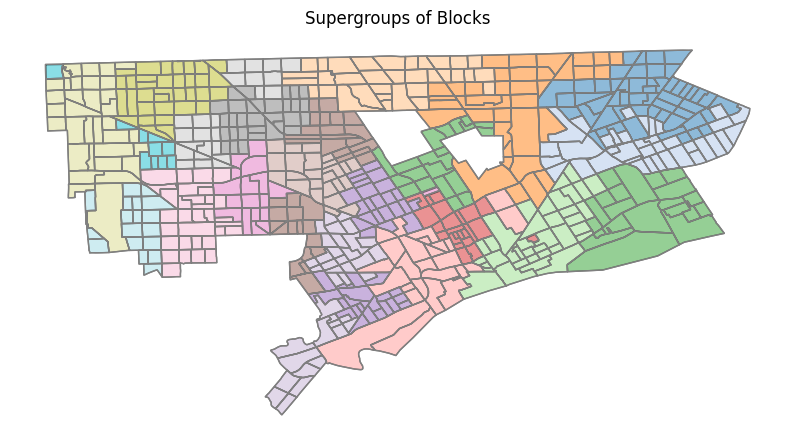

In [19]:
import matplotlib.pyplot as plt

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 10))
gdf.boundary.plot(ax=ax, linewidth=1, color='gray')
colors = plt.cm.get_cmap('tab20', len(supergroups)) 
for i, group in enumerate(supergroups):
    group.plot(ax=ax, color=colors(i), edgecolor='black', alpha=0.5)
ax.set_title('Supergroups of Blocks')
ax.set_axis_off()  

plt.show()

In [20]:
import folium

center = gdf.geometry.centroid.unary_union.centroid
m = folium.Map(location=[center.y, center.x], zoom_start=12)
import random

for i, group in enumerate(supergroups):
    color = "#{:06x}".format(random.randint(0, 0xFFFFFF))
    
    geojson = folium.GeoJson(
        group.geometry.to_json(),
        name=f"Group {i+1}",
        style_function=lambda feature, color=color: {
            'fillColor': color,
            'color': 'black',
            'weight': 1,
            'fillOpacity': 0.5,
        }
    ).add_to(m)
    
    geojson.add_child(folium.Popup(f"Group {i+1}"))

folium.LayerControl().add_to(m)
m

/tmp/ipykernel_419271/586753238.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = gdf.geometry.centroid.unary_union.centroid


## Plotting edges and nodes, will be incorporated into superblocks and folium mapping.

['Place 1', 'Place 2', 'Place 3']


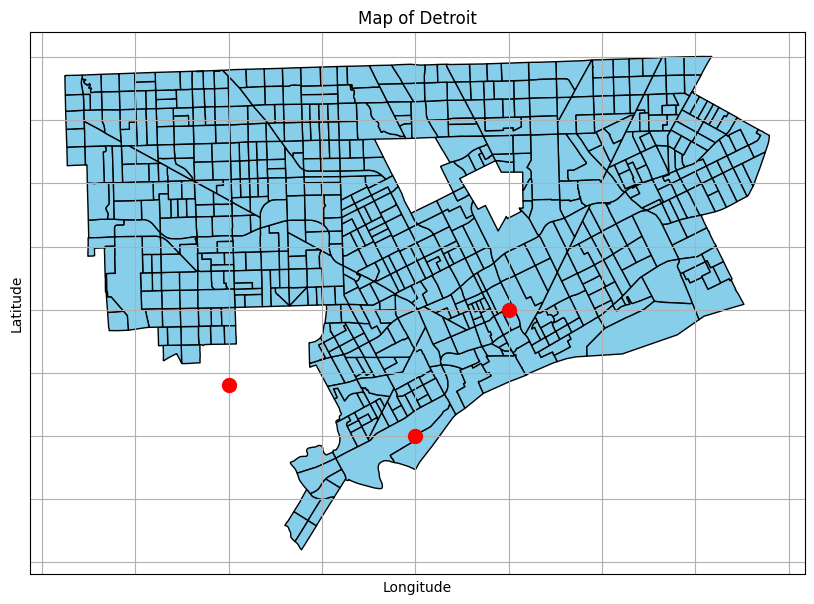

In [21]:
import networkx as nx

def calculate_distance(point, list_point):
    # Initialize an empty list for place, and distance
    list_dist = []
    
    x1, y1 = point
    #Checks the distance for each point in list_point
    for point2 in list_point:
        x2, y2 = point2
        
        # Check that Point is not the same as point 2 
        if point != point2:
            
            # Calcualte distance
            dist = ((x2 - x1) ** 2 + (y2 - y1) ** 2) ** 0.5
            # Creates a list of places and their distances from reference point
            list_dist.append((point2, dist)) 
            
            # Function adapted form stackoverflow (Q: How can you sort a list of tuples by the second item?)
    return sorted(list_dist, key=lambda x: x[1])


def plot_nodes_on_map(detroit_shapefile, places_dict):

    # Reads the shapefile
    detroit = gpd.read_file(detroit_shapefile)

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot the shapefile
    detroit.plot(ax=ax, color='skyblue', edgecolor='black')

    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes at specified coordinates
    for place, coords in places_dict.items():
        # Add node to the graph
        G.add_node(place, pos=coords)

    print(G.nodes)

    # Draw nodes 
    nx.draw_networkx_nodes(G, pos=places_dict, node_size=100, ax=ax, node_color='red')

    # Set title, labels, and grid
    plt.title('Map of Detroit')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)

    # Display the plot
    plt.show()

# Example 
places_coordinates = {
    "Place 1": (-83.05, 42.35),
    "Place 2": (-83.10, 42.30),
    "Place 3":(-83.20, 42.32)
}

# Path to shapefile
detroit_shapefile = 'datasets'

#Call function
plot_nodes_on_map(detroit_shapefile, places_coordinates)

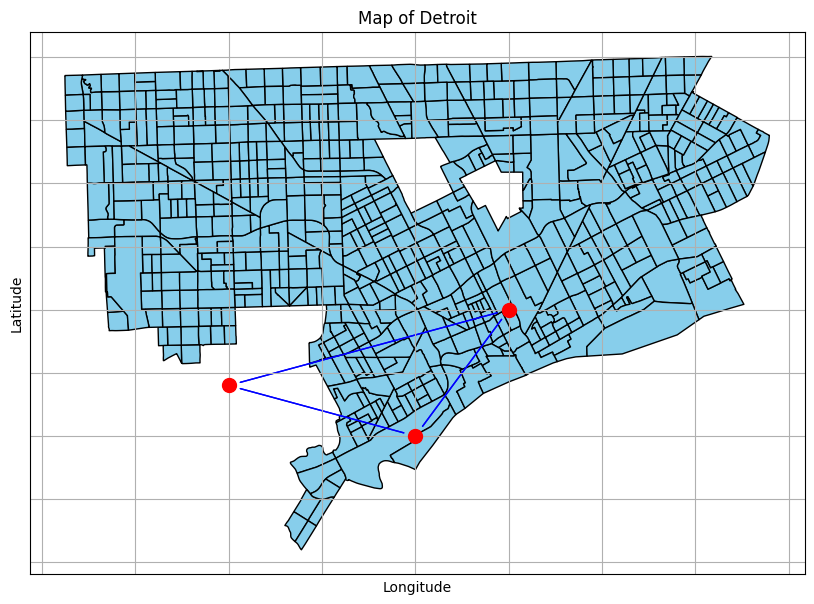

In [22]:
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt

# Calculates the distance between two points
def distance(coord1, coord2):
    x1, y1 = coord1
    x2, y2 = coord2
    return ((x2 - x1) ** 2 + (y2 - y1) ** 2) ** 0.5


# Returns a dictionary of closest to farthest neighbors
def closest_neighbors(places_dict, target_point):

    # Initialize an empty dictionary 
    distances = {}
    
    for location, coord in places_dict.items():

        # Check that we are not comparing two of the same points
        if coord != target_point:
            
            # The location as a key and its distance as the value.
            distances[location] = distance(coord, target_point)

    # Sort distances from closest to farthest
    sorted_distances = sorted(distances.items(), key=lambda x: x[1])
    
    return sorted_distances

def nodes_edges(detroit_shapefile, places_dict):

    # Reads the shapefile
    detroit = gpd.read_file(detroit_shapefile)

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot the shapefile
    detroit.plot(ax=ax, color='skyblue', edgecolor='black')

    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes at specified coordinates
    for place, coords in places_dict.items():
        # Add node to the graph
        G.add_node(place, pos=coords)

    # Call the distance function to get a list of distances 
    for place, coords in places_dict.items():
        
        dist = closest_neighbors(places_dict, coords)
        
        closest1 = dist[0][0] # Name of the closest neighbor
        closest2 = dist[1][0] # Name of the second closest neighbor

        # Add edges to the two closest neighbors
        G.add_edge(place, closest1) 
        G.add_edge(place, closest2)

    # Draw nodes 
    nx.draw_networkx_nodes(G, pos=places_dict, node_size=100, ax=ax, node_color='red')

    # Draw edges 
    nx.draw_networkx_edges(G, pos=places_dict, ax=ax, edge_color='blue', arrowstyle='-')

    # Set title, labels, and grid
    plt.title('Map of Detroit')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)

    # Display the plot
    plt.show()

# Example of places and their coordinates
places_coordinates = {
    "Place 1": (-83.05, 42.35),
    "Place 2": (-83.10, 42.30),
    "Place 3":(-83.20, 42.32)
}

# Path to shapefile
detroit_shapefile = 'datasets'

#Call the function
nodes_edges(detroit_shapefile, places_coordinates)

### Making a list of coordinates to get nodes in block_groups, next implementation will be in superblocks.

In [23]:
#Returns a numpy array of x and y coordinates for the centroid of blockgroups. Order kept from shapefile.


In [24]:
x_y = gdf['geometry'].geometry.centroid

/tmp/ipykernel_419271/3361704846.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  x_y = gdf['geometry'].geometry.centroid


In [25]:
import Train

train = Train()

SyntaxError: non-default argument follows default argument (Train.py, line 3)

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

def find_adjacent_blocks(block, gdf):
    """
    Finds blocks adjacent to the given block.
    """
    adjacent = gdf[gdf.geometry.touches(block.geometry)]
    return adjacent

def group_blocks(gdf, target_population, margin=1000):
    """
    Groups blocks into supergroups based on adjacency and population criteria.
    """
    grouped_blocks = []
    centroids = []
    visited = set()
    
    for index, block in gdf.iterrows():
        if index in visited:
            continue
        
        current_group = [block]
        current_population = block['VALUE9']
        queue = [block]
        visited.add(index)
        
        while queue:
            current_block = queue.pop(0)
            if current_population >= target_population - margin and current_population <= target_population + margin:
                break
            
            adjacents = find_adjacent_blocks(current_block, gdf)
            
            for _, adj_block in adjacents.iterrows():
                adj_index = adj_block.name
                if adj_index not in visited and current_population + adj_block['VALUE9'] <= target_population + margin:
                    visited.add(adj_index)
                    current_group.append(adj_block)
                    current_population += adj_block['VALUE9']
                    queue.append(adj_block)
        
        if current_group:
            supergroup = gpd.GeoDataFrame(current_group)
            grouped_blocks.append(supergroup)
            centroids.append(supergroup.unary_union.centroid)
    
    return grouped_blocks, centroids
target_population = 20000
margin = 2000
supergroups, centroids = group_blocks(gdf, target_population, margin)
fig, ax = plt.subplots(figsize=(10, 10))
gdf.boundary.plot(ax=ax, linewidth=1, color='gray')
colors = plt.cm.get_cmap('tab20', len(supergroups))
for i, (group, centroid) in enumerate(zip(supergroups, centroids)):
    group.plot(ax=ax, color=colors(i), edgecolor='black', alpha=0.5)
    plt.plot(centroid.x, centroid.y, 'k*', markersize=10)  
ax.set_title('Supergroups of Blocks with Centroids')
ax.set_axis_off()

plt.show()


In [ ]:
import networkx as nx

def find_adjacent_blocks(block, gdf):
    """
    Finds blocks adjacent to the given block.
    
    Parameters:
    - block: The GeoDataFrame row of the current block.
    - gdf: The entire GeoDataFrame of blocks.
    
    Returns:
    - A GeoDataFrame of adjacent blocks.
    """
    adjacent = gdf[gdf.geometry.touches(block.geometry)]
    return adjacent

def group_blocks(gdf, target_population, margin=1000):
    """
    Groups blocks into superblocks based on adjacency and population criteria.
    
    Parameters:
    - gdf: GeoDataFrame containing all blocks with their population.
    - target_population: The target population for each superblock.
    - margin: The margin of error for the target population.
    
    Returns:
    - A list of GeoDataFrames, each representing a grouped superblock.
    """
    grouped_blocks = []
    visited = set()
    
    for index, block in gdf.iterrows():
        if index in visited:
            continue
        
        current_group = [block]
        current_population = block['VALUE9']
        queue = [block]
        visited.add(index)
        
        while queue:
            current_block = queue.pop(0)
            if current_population >= target_population - margin and current_population <= target_population + margin:
                break
            
            adjacents = find_adjacent_blocks(current_block, gdf)
            
            for _, adj_block in adjacents.iterrows():
                adj_index = adj_block.name
                if adj_index not in visited and current_population + adj_block['VALUE9'] <= target_population + margin:
                    visited.add(adj_index)
                    current_group.append(adj_block)
                    current_population += adj_block['VALUE9']
                    queue.append(adj_block)
        
        if current_group:
            grouped_blocks.append(gpd.GeoDataFrame(current_group))
    
    return grouped_blocks

gdf = gpd.read_file("datasets")
target_population = 19000
margin = 2000
supergroups = group_blocks(gdf, target_population, margin)
G = nx.Graph()
pos = {}
for i, group in enumerate(supergroups):
    superblock = group.unary_union
    centroid = superblock.centroid
    G.add_node(i)
    pos[i] = (centroid.x, centroid.y)

fig, ax = plt.subplots(figsize=(10, 10))
gdf.boundary.plot(ax=ax, linewidth=1, color='gray')
colors = plt.cm.get_cmap('tab20', len(supergroups))
for i, group in enumerate(supergroups):
    group.plot(ax=ax, color=colors(i), edgecolor='black', alpha=0.5)
ax.set_title('Supergroups of Blocks with NetworkX Nodes')
ax.set_axis_off()
for node, (x, y) in pos.items():
    ax.plot(x, y, marker='o', color='red', markersize=5)

plt.show()


In [ ]:
import numpy as np
coordinates_list = list(pos.values())
coordinates_array = np.array(coordinates_list)
coordinates_array

In [26]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial import distance

def plot_minimum_spanning_tree(coordinates):
    G = nx.complete_graph(len(coordinates))
    for i, (x1, y1) in enumerate(coordinates):
        for j, (x2, y2) in enumerate(coordinates):
            if i < j:
                dist = distance.euclidean((x1, y1), (x2, y2))
                G[i][j]['weight'] = dist
    mst = nx.minimum_spanning_tree(G)
    pos = {i: coord for i, coord in enumerate(coordinates)}
    plt.figure(figsize=(10, 8))
    nx.draw(mst, pos, with_labels=True, node_size=100, edge_color='blue', node_color='green')
    plt.title('Minimum Spanning Tree')
    plt.show()
coordinates = coordinates_array

plot_minimum_spanning_tree(coordinates)


NameError: name 'coordinates_array' is not defined

In [ ]:
coordinates = coordinates_array
G = nx.complete_graph(len(coordinates))
for i, coord1 in enumerate(coordinates):
    for j, coord2 in enumerate(coordinates):
        if i < j:
            dist = distance.euclidean(coord1, coord2)
            G.add_edge(i, j, weight=dist)
mst = nx.minimum_spanning_tree(G)
for edge in mst.edges():
    point1 = coordinates[edge[0]]
    point2 = coordinates[edge[1]]
    line = folium.PolyLine(locations=[point1[::-1], point2[::-1]], weight=2, color='blue')
    line.add_to(m)
m
